In [77]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import credentials
import re


In [51]:
#specific twitter user client class 

class TwitterClient():
    
    def __init__(self, twitter_user = None):
        
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitterclient = API(self.auth)
        self.twitter_user = twitter_user
        
    def get_client_api(self):
        return self.twitterclient
        
    #Gets tweets off of users timeline using Cursor and API class. Uses num_tweets to get a specific amount    
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        #loops through every tweet that cursor has and adds it to list tweets
        for tweet in Cursor(self.twitterclient.user_timeline, id = self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
     #Gets friends off of user using Cursor and API class. Uses num_tweets to get a specific amount
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitterclient.friends).items(num_friends):
            friends_list.append(friend)
        return friend_list
    
     #Gets home timeline off of user using Cursor and API class. Uses num_tweets to get a specific amount
    def get_home_timeline_tweets(self, num_tweets):
        home = []
        for tweets in Cursor(self.twitterclient.home_timeline, id = self.twitter_user).items(num_friends):
            home.append(tweets)
        return home

In [52]:
#api authentication

class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(credentials.API_KEY, credentials.API_SECRET)
        auth.set_access_token(credentials.ACCESS_TOKEN, credentials.ACCESS_TOKEN_SECRET)
        return auth

In [53]:
#streaming and processing live tweets

class TwitterStreamer():
    
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
    
    def streamtweets(self, fetched_tweets_filename, hashtag_list):
        #authenticates the app
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth, listener)
        
        #filters twitter stream for specific hashtags
        stream.filter(track = hashtag_list)


In [54]:
#prints out tweets to twitter listener
class TwitterListener(StreamListener):
    
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename
    
    #Overidden Method that takes in the data from StreamListener (Tweets)
    
    def on_data(self, data):
        
        try: 
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e: 
            print('Error on Data : %s' % str(e))
            
        return True
    
    #Overiden method that happens when an error occurs like rate limits
    
    def on_error(self, status):
        
        if status == 420:
            #returns false if rate limit occurs
            return False
        
        print(status)
        
                

In [83]:


#anlayzes and categorizes the tweet

class TweetAnalyzer():
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        
        analysis = TextBlob(self.clean_tweet(tweet))
        
        # Tests if the tweet was interpreted positively, neutral, or negative
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else: 
            return -1
    
    def tweets_to_df(self, tweets):
        
        df = pd.DataFrame(data = [tweet.text for tweet in tweets], columns = ['tweets'])
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        
        return df

In [86]:

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    
    api = twitter_client.get_client_api()
    
    tweets = api.user_timeline(screen_name="JoeBiden", count=200)
    
    df = tweet_analyzer.tweets_to_df(tweets)
  
  
    #adding sentiment column to dataframe
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    print(df.head(10))

                                              tweets                   id  \
0  Grassroots supporters made it possible for us ...  1398663242675806212   
1  Before we took office, the economy added back ...  1398385137402843137   
2  To put it simply, America's coming back. https...  1398335999349035012   
3  RT @POTUS: America is on the move again. We’ve...  1398293173349277704   
4  This is our moment to rebuild an economy from ...  1398083579075350528   
5  The Biden economic plan is working. https://t....  1398039819947741185   
6  RT @POTUS: Tune in as I deliver remarks on our...  1397980959723696137   
7  RT @POTUS: We are still awaiting many of the d...  1397694754528313350   
8  Enjoyed meeting with Maria and Dreamers this m...  1397655816426119173   
9  Across the country, we have failed to properly...  1397297809410433027   

   len                date                source  likes  retweets  sentiment  
0  140 2021-05-29 15:31:17       Twitter Web App   6534      1009        

In [78]:
    #get average length of tweets
    print("Mean tweets", np.mean(df['len']))
    
    #get number of likes for most liked tweets
    print("Max tweets", np.max(df['likes']))
    
    #get number of retweets for most retweets tweets
    print("Max Retweets", np.max(df['retweets']))

Mean tweets 130.375
Max tweets 243309
Max Retweets 34776


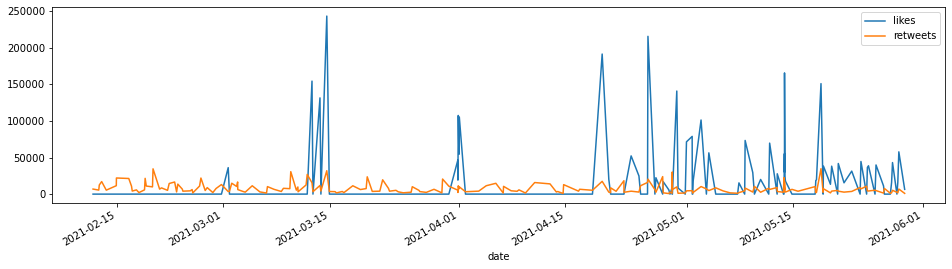

In [79]:
    #Layered Time Series:#
    
    time_likes = pd.Series(data=df['likes'].values, index=df['date'])
    time_likes.plot(figsize=(16, 4), label="likes", legend=True)

    time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
    plt.show()